In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Best Model

In [47]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
import matplotlib.pyplot as plt

In [48]:
data_dir = '/content/drive/MyDrive/divided_datathon_dataset_pre'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define image dimensions and other parameters
img_width, img_height = 64, 64
batch_size = 32
num_classes = 4  # Number of tumor types


In [49]:
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1938 images belonging to 4 classes.
Found 647 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [50]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))

# softmax
model.add(Dense(4, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 dropout_16 (Dropout)        (None, 62, 62, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 62, 64)        51264     
                                                                 
 batch_normalization_8 (Batc  (None, 62, 62, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 dropout_17 (Dropout)        (None, 31, 31, 64)       

In [51]:
#compile

from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam, Nadam, SGD


opt=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model.compile(loss="categorical_crossentropy",
             optimizer=opt,
             metrics=["accuracy", Precision(), Recall()])

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1)


model_checkpoint =  ModelCheckpoint('best_model.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           mode='auto',period=1)

In [53]:
#Fitting model on train data
history=model.fit(train_generator,
                  batch_size=50,
                  epochs=100,
                  validation_data=validation_generator,
                  verbose=1,
                  callbacks=[early_stopping,model_checkpoint, reduce_lr])



Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 3.6332 - accuracy: 0.4639 - precision_4: 0.4803 - recall_4: 0.4020
Epoch 1: val_loss improved from inf to 6.54063, saving model to best_model.h5
61/61 [==============================] - 13s 170ms/step - loss: 3.6332 - accuracy: 0.4639 - precision_4: 0.4803 - recall_4: 0.4020 - val_loss: 6.5406 - val_accuracy: 0.2875 - val_precision_4: 0.2884 - val_recall_4: 0.2875 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.8966 - accuracy: 0.6404 - precision_4: 0.7058 - recall_4: 0.5299
Epoch 2: val_loss did not improve from 6.54063
61/61 [==============================] - 9s 153ms/step - loss: 0.8966 - accuracy: 0.6404 - precision_4: 0.7058 - recall_4: 0.5299 - val_loss: 10.0121 - val_accuracy: 0.3277 - val_precision_4: 0.3277 - val_recall_4: 0.3277 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7224 - precision_4: 0.7721 - recall_4: 0.63

In [54]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)


21/21 [==============================] - 2s 108ms/step - loss: 0.5245 - accuracy: 0.8659 - precision_4: 0.8674 - recall_4: 0.8567


In [55]:
test_loss,test_accuracy

(0.5244798064231873, 0.8659476041793823)

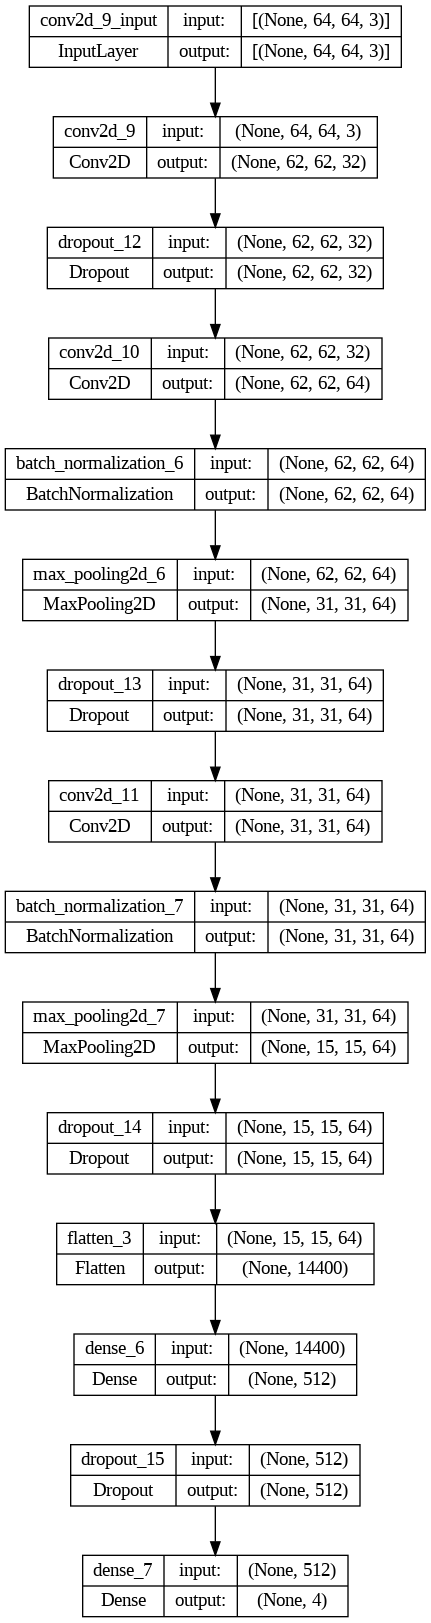

In [44]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)